In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense , Dropout
from keras.optimizers import RMSprop , adam
from keras.utils import to_categorical
from keras.models import load_model

import tensorflow as tf
from tensorflow.python.platform import flags

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder , MinMaxScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder , MinMaxScaler

from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StringType, IntegerType, StructType
from pyspark.sql.functions import *
#from pyspark.ml.feature import OneHotEncoder, StringIndexer
#from pyspark.ml.feature import MinMaxScaler
#from pyspark.ml.linalg import Vectors

Using TensorFlow backend.


In [2]:
#Preprossessing Dataset i.e KDD Test and Training data using SparkSession
spark = SparkSession.builder.appName("cybersecurity").getOrCreate()
df_test = spark.read.csv('KDDTest+.csv',inferSchema=True,header=False).toDF("duration", "protocol" , "service" , "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", 
         "hot", "num_failed_logins", "logged_in ", "num_compromised", "root_shell", "su_attempted", "num_root", 
         "num_file_creations", "num_shells", "num_access_files","num_outbound_cmds ","is_host_login ", "is_guest_login",
         "count", "srv_count", "serror_rate", "srv_serror_rate","rerror_rate", "srv_rerror_rate", "same_srv_rate", 
         "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", " dst_host_srv_count", "dst_host_same_srv_rate", 
         "dst_host_diff_srv_rate","dst_host_same_src_port_rate", " dst_host_srv_diff_host_rate", "dst_host_serror_rate",
         "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "attack_type", "other")
df_train = spark.read.csv('KDDTrain+.csv',inferSchema=True,header=False).toDF("duration", "protocol" , "service" , "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", 
         "hot", "num_failed_logins", "logged_in ", "num_compromised", "root_shell", "su_attempted", "num_root", 
         "num_file_creations", "num_shells", "num_access_files","num_outbound_cmds ","is_host_login ", "is_guest_login",
         "count", "srv_count", "serror_rate", "srv_serror_rate","rerror_rate", "srv_rerror_rate", "same_srv_rate", 
         "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", " dst_host_srv_count", "dst_host_same_srv_rate", 
         "dst_host_diff_srv_rate","dst_host_same_src_port_rate", " dst_host_srv_diff_host_rate", "dst_host_serror_rate",
         "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "attack_type", "other")

In [3]:
#Combine both Test and Train Data
df = df_train.union(df_test)


In [4]:
#DOS Attacks
df = df.na.replace(["neptune", "back", "land", "pod", "smurf", "teardrop", "mailbomb", "processtable", "udpstorm", "apache2", "worm"], "dos", "attack_type")

#User to Root Attacks
df = df.na.replace(["buffer_overflow", "loadmodule", "perl", "rootkit", "sqlattack", "xterm", "ps"], "u2r", "attack_type")

#Remote to Local Attacks
df = df.na.replace(["ftp_write", "guess_passwd", "imap", "multihop", "phf", "spy", "warezclient", "warezmaster", "xlock", "xsnoop", "snmpgetattack", "httptunnel", "snmpguess", "sendmail", "named"], "r2l", "attack_type")

#Probe Attacks
df = df.na.replace(["satan", "ipsweep", "nmap", "portsweep", "saint", "mscan"], "probe", "attack_type")


In [5]:
X = df.select(df.columns[:-2])
y = df.select(df.columns[41])

In [6]:
#Convert to Pandas Dataframe
X= X.toPandas()
y = y.toPandas()

In [7]:
X.head()

,duration,protocol,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,udp,other,SF,146,0,0,0,0,0,...,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,tcp,private,S0,0,0,0,0,0,0,...,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,tcp,http,SF,232,8153,0,0,0,0,...,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [8]:
y.attack_type.unique()

array(['normal', 'dos', 'r2l', 'probe', 'u2r'], dtype=object)

In [9]:
#Apply Label Encoding and One Hot Encoding to Y Data which resembles classes for different attack types
label_encoder = LabelEncoder()
label_encoder.fit(y)
encoded_y = label_encoder.transform(y)

one_hot_y = to_categorical(encoded_y)
one_hot_y

/Users/jayachandranjohn/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jayachandranjohn/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.]], dtype=float32)

In [10]:
X = pd.get_dummies(X,drop_first = False)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, one_hot_y, random_state=42)

In [12]:
# Next, we normalize our training data to be between 0 and 1

# The fit method calculates the min and max of our original training data
scaler = MinMaxScaler().fit(X_train)

# The transform method transforms the original values to a range between 0 and 1
# using the min and max computed above
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Decision Tree Classifier

In [14]:
#Accuracy using Decision Tree Classifier

clf = DecisionTreeClassifier()
clf = clf.fit(X_train_scaled, y_train)
dt_score = clf.score(X_test_scaled, y_test)
dt_score

0.9919200624848501

# Random Forest Classifier

In [15]:
#Accuracy using Random Forest Classifier

rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train_scaled, y_train)
rf_score=rf.score(X_test_scaled, y_test)
rf_score

0.99429017748929405

# K Nearest Neighbor

k: 1, Train/Test Score: 0.999/0.992
k: 3, Train/Test Score: 0.995/0.991
k: 5, Train/Test Score: 0.993/0.990
k: 7, Train/Test Score: 0.991/0.989


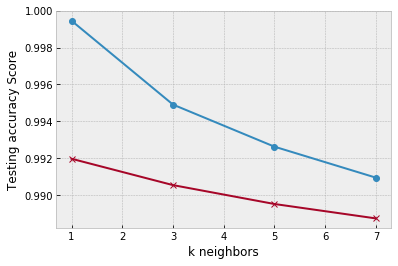

In [55]:
#Accuracy using K Nearest Neighbor
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 8, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 8, 2), train_scores, marker='o')
plt.plot(range(1, 8, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [56]:
# Note that k: 7 provides the best accuracy where the classifier starts to stablize
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
knn_score = knn.score(X_test, y_test)
print('k=7 Test Acc: %.3f' % knn_score)

k=7 Test Acc: 0.983


In [21]:
X_train.shape

(111387, 122)

# Deep Learning

In [37]:
# first, create a normal neural network with 122 inputs, 6 hidden nodes, and 5 outputs
model = Sequential()
model.add(Dense(units=6, activation='relu', input_dim=122))
model.add(Dense(units=5, activation='softmax'))

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 6)                 738       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 35        
Total params: 773
Trainable params: 773
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# Fit the model to the training data
model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
 - 5s - loss: 0.2588 - acc: 0.9202
Epoch 2/100
 - 5s - loss: 0.1252 - acc: 0.9592
Epoch 3/100
 - 5s - loss: 0.1104 - acc: 0.9616
Epoch 4/100
 - 5s - loss: 0.1019 - acc: 0.9638
Epoch 5/100
 - 5s - loss: 0.0957 - acc: 0.9655
Epoch 6/100
 - 5s - loss: 0.0910 - acc: 0.9668
Epoch 7/100
 - 5s - loss: 0.0872 - acc: 0.9682
Epoch 8/100
 - 5s - loss: 0.0837 - acc: 0.9696
Epoch 9/100
 - 5s - loss: 0.0805 - acc: 0.9705
Epoch 10/100
 - 5s - loss: 0.0770 - acc: 0.9727
Epoch 11/100
 - 5s - loss: 0.0739 - acc: 0.9740
Epoch 12/100
 - 5s - loss: 0.0713 - acc: 0.9758
Epoch 13/100
 - 5s - loss: 0.0687 - acc: 0.9767
Epoch 14/100
 - 6s - loss: 0.0667 - acc: 0.9779
Epoch 15/100
 - 5s - loss: 0.0651 - acc: 0.9785
Epoch 16/100
 - 5s - loss: 0.0640 - acc: 0.9786
Epoch 17/100
 - 5s - loss: 0.0628 - acc: 0.9794
Epoch 18/100
 - 5s - loss: 0.0622 - acc: 0.9795
Epoch 19/100
 - 5s - loss: 0.0617 - acc: 0.9793
Epoch 20/100
 - 5s - loss: 0.0612 - acc: 0.9793
Epoch 21/100
 - 5s - loss: 0.0605 - acc: 0.9802
E

In [41]:
model_loss, model_accuracy = model.evaluate(
    X_test_scaled, y_test, verbose=2)
print(
    f"Normal Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

Normal Neural Network - Loss: 0.05222453046596612, Accuracy: 0.9837054593444478


In [42]:
#For this network, we simply add an additional hidden layer of 6 nodes
deep_model = Sequential()
deep_model.add(Dense(units=6, activation='relu', input_dim=122))
deep_model.add(Dense(units=6, activation='relu'))
deep_model.add(Dense(units=5, activation='softmax'))

In [43]:
deep_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 6)                 738       
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 35        
Total params: 815
Trainable params: 815
Non-trainable params: 0
_________________________________________________________________


In [47]:
deep_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

deep_model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    shuffle=True,
    verbose=2
)

Epoch 1/100
 - 6s - loss: 0.2518 - acc: 0.9251
Epoch 2/100
 - 5s - loss: 0.1143 - acc: 0.9628
Epoch 3/100
 - 5s - loss: 0.0987 - acc: 0.9677
Epoch 4/100
 - 5s - loss: 0.0895 - acc: 0.9708
Epoch 5/100
 - 6s - loss: 0.0825 - acc: 0.9729
Epoch 6/100
 - 7s - loss: 0.0773 - acc: 0.9746
Epoch 7/100
 - 6s - loss: 0.0732 - acc: 0.9757
Epoch 8/100
 - 5s - loss: 0.0696 - acc: 0.9772
Epoch 9/100
 - 6s - loss: 0.0665 - acc: 0.9784
Epoch 10/100
 - 7s - loss: 0.0644 - acc: 0.9788
Epoch 11/100
 - 7s - loss: 0.0625 - acc: 0.9796
Epoch 12/100
 - 6s - loss: 0.0605 - acc: 0.9800
Epoch 13/100
 - 5s - loss: 0.0593 - acc: 0.9811
Epoch 14/100
 - 5s - loss: 0.0583 - acc: 0.9816
Epoch 15/100
 - 5s - loss: 0.0573 - acc: 0.9819
Epoch 16/100
 - 5s - loss: 0.0562 - acc: 0.9819
Epoch 17/100
 - 6s - loss: 0.0548 - acc: 0.9826
Epoch 18/100
 - 5s - loss: 0.0538 - acc: 0.9825
Epoch 19/100
 - 5s - loss: 0.0531 - acc: 0.9831
Epoch 20/100
 - 5s - loss: 0.0527 - acc: 0.9831
Epoch 21/100
 - 5s - loss: 0.0521 - acc: 0.9834
E

In [48]:
model_loss, model_accuracy = deep_model.evaluate(
    X_test_scaled, y_test, verbose=2)
print(f"Deep Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

Deep Neural Network - Loss: 0.04516289862386852, Accuracy: 0.9852945137240325


In [49]:
# Save the model
deep_model.save("cybersecurity_ml_model_trained.h5")

In [50]:
# Load the model
cybersecurity_ml_model = load_model("cybersecurity_ml_model_trained.h5")

In [51]:
model_loss, model_accuracy = cybersecurity_ml_model.evaluate(
    X_test_scaled, y_test, verbose=2)
print(
    f"Deep Neural Network - Loss: {model_loss}, Accuracy: {model_accuracy}")

Deep Neural Network - Loss: 0.04516289862386852, Accuracy: 0.9852945137240325


# Comparison of different ML Classifiers

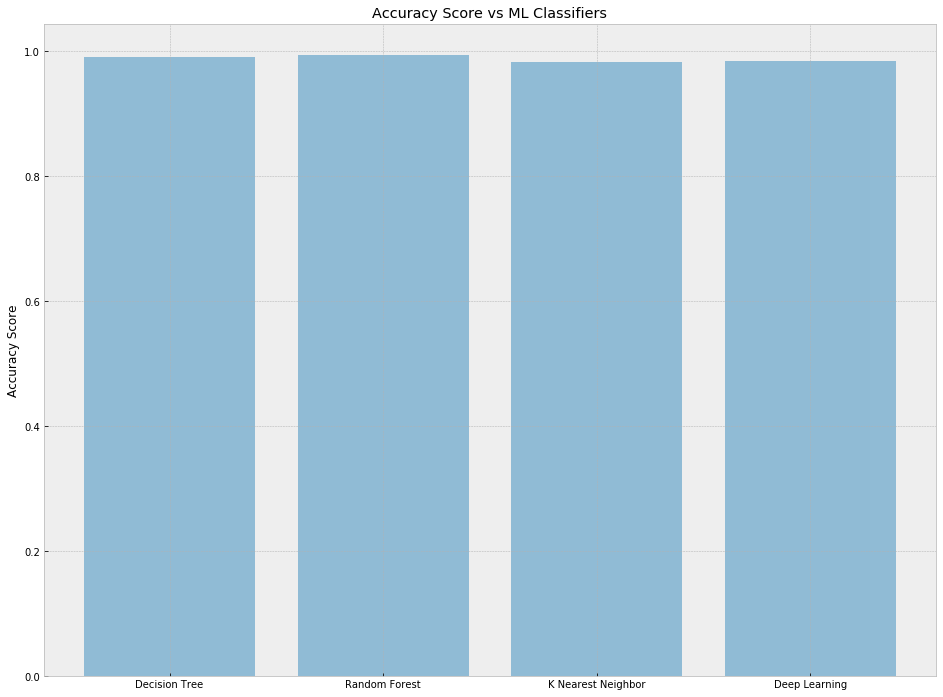

In [58]:

classifiers = ('Decision Tree', 'Random Forest', 'K Nearest Neighbor', 'Deep Learning')
y_pos = np.arange(len(classifiers))
score = [dt_score, rf_score, knn_score, model_accuracy]

plt . figure ( figsize =(16 , 12) ) 
plt.bar(y_pos, score, align='center', alpha=0.5)
plt.xticks(y_pos, classifiers)
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs ML Classifiers')
plt.savefig("Accuracy_Score_Vs_ML_Classifiers")
plt.show()

In [59]:
spark.stop()